# Prepare the data

In [27]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
%matplotlib inline

### Load data & tokenize

In [28]:
words = open('names.txt', 'r').read().splitlines()
chars = ['.'] + sorted(list(set("".join(words))))
vocab_size = len(chars)

stoi = {char:i for i, char in enumerate(chars)}
itos = {i: char for char, i  in stoi.items()}

print(len(words))
print(vocab_size)

32033
27


### Create a train/val/tast split

In [29]:
block_size = 6

def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0]*block_size
        for ch in w+'.':
            ix = stoi[ch]
            Y.append(ix)
            X.append(context)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

import random
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

# MLP

### Initialize parameters

In [30]:
embed_size = 10
hidden_size = 300

In [62]:
E = torch.randn((vocab_size, embed_size))       # 27 x 10
W1 = torch.randn((embed_size*block_size, hidden_size))  * 0.2 # 60 x 300
b1 = torch.randn(hidden_size) * 0.01                          # 300
W2 = torch.randn((hidden_size, vocab_size)) * 0.01           # 300 x 27
b2 = torch.randn(vocab_size) * 0                   #  27
parameters = [E, W1, W2, b1, b2]
for p in parameters:
    p.requires_grad = True

In [63]:
# Number of parameters in the model
params = sum(p.nelement() for p in parameters)
params

26697

# Training

In [64]:
lre = torch.linspace(-3, 0, 1000) 
lrs = 100**lre

In [65]:
lri= []
lossi = []
stepi = []

In [66]:
max_steps = 200000
batch_size = 64
for _ in range(max_steps):
    
    ix = torch.randint(1, Xtr.shape[0], (batch_size, ))
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    
    emb = E[Xb]
    h = torch.tanh(emb.view(-1, embed_size*block_size) @ W1 + b1)
    logits = h @ W2 +b2
    loss = F.cross_entropy(logits, Yb)
    
    
    for p in parameters:
        p.grad = None
    
    loss.backward()
    
    lr = 0.1 if _ < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    # lri.append(lre[_])
    if _ % 10000 ==0:
        print(f'loss on {_} steps is: {loss.item()}')
    lossi.append(loss.log10().item())

    # break

loss on 0 steps is: 3.3171515464782715
loss on 10000 steps is: 2.291857957839966
loss on 20000 steps is: 2.139390707015991
loss on 30000 steps is: 2.0435609817504883
loss on 40000 steps is: 1.6811728477478027
loss on 50000 steps is: 1.969591498374939
loss on 60000 steps is: 1.9491020441055298
loss on 70000 steps is: 1.8511663675308228
loss on 80000 steps is: 2.0804755687713623
loss on 90000 steps is: 2.1647820472717285
loss on 100000 steps is: 2.0332980155944824
loss on 110000 steps is: 1.856414556503296
loss on 120000 steps is: 1.8713831901550293
loss on 130000 steps is: 2.0554351806640625
loss on 140000 steps is: 1.9869471788406372
loss on 150000 steps is: 1.656663179397583
loss on 160000 steps is: 2.094557285308838
loss on 170000 steps is: 1.6105057001113892
loss on 180000 steps is: 1.9292129278182983
loss on 190000 steps is: 1.7278624773025513


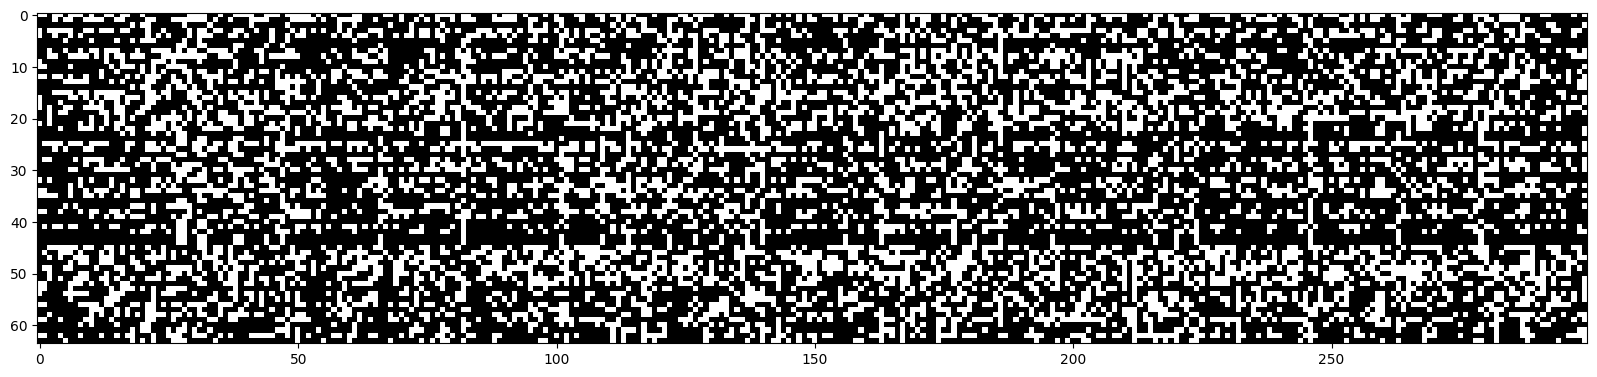

In [67]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > .99, cmap='grey', interpolation='nearest')

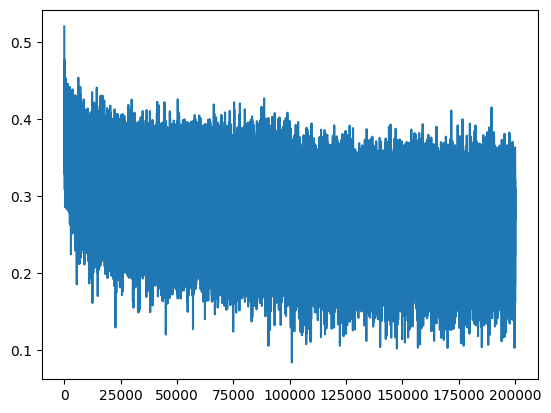

In [68]:
plt.plot(lossi)

### Evaluating loss

In [38]:
emb = E[Xtr]
h = torch.tanh(emb.view(-1, embed_size*block_size) @ W1 + b1)
logits = h @ W2 +b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(3.2366, grad_fn=<NllLossBackward0>)

In [69]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    emb = E[Xte]
    h = torch.tanh(emb.view(-1, embed_size*block_size) @ W1 + b1)
    logits = h @ W2 +b2
    loss = F.cross_entropy(logits, Yte)
    print(split,  loss.item())
    
split_loss('train')
split_loss('val')
    

train 2.0531129837036133
val 2.0531129837036133


In [40]:
emb = E[Xte]
h = torch.tanh(emb.view(-1, embed_size*block_size) @ W1 + b1)
logits = h @ W2 +b2
loss = F.cross_entropy(logits, Yte)
loss

tensor(3.2353, grad_fn=<NllLossBackward0>)

# Sampling from the model

In [70]:
for i in range(20):
    out = []
    context = [0]*block_size
    while True:
        emb1 = E[torch.tensor([context])]
        h = torch.tanh(emb1.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        p = F.softmax(logits, dim=1)
        ix = torch.multinomial(p, num_samples=1).item()
        context = context[1:] + [ix]
        out.append(ix)

        if ix ==0:
            break
        
    print(''.join(itos[i] for i in out ))

markis.
mirae.
aslie.
saulie.
neuka.
eylo.
marecha.
lariya.
kathart.
zabish.
judnan.
rollins.
odisandi.
tana.
nathaan.
cantiel.
aladyi.
chuth.
calin.
ayno.


## Pretty good))